# Bean Disease Classification - Model Performance Testing

This notebook evaluates the performance of trained models (TensorFlow and TFLite) on the complete dataset.

Since we don't know which images were used for training, we test on all available data to get a comprehensive performance assessment.

## Setup

In [1]:
import os
import sys

# Basic configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TF logging

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import time
from pathlib import Path
import gc

# Import tfds properly to avoid lazy loading issues
import tensorflow_datasets as tfds
_ = tfds.core

# Configure GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Configured {len(gpus)} GPU(s) with memory growth")
    except RuntimeError as e:
        print(f"GPU configuration: {e}")

print("✓ Setup complete")

2025-10-08 10:46:47.818714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759913207.838880   45399 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759913207.844767   45399 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759913207.861712   45399 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759913207.861766   45399 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759913207.861768   45399 computation_placer.cc:177] computation placer alr

✓ Configured 1 GPU(s) with memory growth
✓ Setup complete


In [2]:
# Configuration
MODELS = {
    'xception_keras': 'models/xception.keras',
    'xception_tflite': 'models/xception.tflite',
    'mobilenet_keras': 'models/mobile_net.keras',
    'mobilenet_tflite': 'models/mobile_net.tflite'
}

# Class names
CLASS_NAMES = ["Angular Leaf Spot", "Bean Rust", "Healthy"]
N_CLASSES = len(CLASS_NAMES)

# Image preprocessing
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

print("Models to evaluate:")
for name, path in MODELS.items():
    print(f"  - {name}: {path}")

Models to evaluate:
  - xception_keras: models/xception.keras
  - xception_tflite: models/xception.tflite
  - mobilenet_keras: models/mobile_net.keras
  - mobilenet_tflite: models/mobile_net.tflite


## Load Dataset

We load the complete beans dataset for testing.

In [3]:
# Load complete dataset
print("Loading bean disease dataset...")

# Use builder API which is more reliable in tfds 4.9+
builder = tfds.builder("beans")
builder.download_and_prepare()
ds_all = builder.as_dataset(split="all", as_supervised=True, shuffle_files=False)
info = builder.info

# Get dataset info
total_samples = info.splits['all'].num_examples
print(f"Total samples: {total_samples}")
print(f"Classes: {info.features['label'].names}")

Loading bean disease dataset...
Total samples: 1295
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


I0000 00:00:1759913212.786073   45399 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [4]:
# Extract all images and labels for evaluation
all_images = []
all_labels = []

for image, label in ds_all:
    all_images.append(image.numpy())
    all_labels.append(label.numpy())

all_labels = np.array(all_labels)
print(f"Loaded {len(all_images)} images")

# Show class distribution
unique, counts = np.unique(all_labels, return_counts=True)
print("\nClass distribution:")
for cls, count in zip(unique, counts):
    print(f"  {CLASS_NAMES[cls]}: {count} ({count/len(all_labels)*100:.1f}%)")

Loaded 1295 images

Class distribution:
  Angular Leaf Spot: 432 (33.4%)
  Bean Rust: 436 (33.7%)
  Healthy: 427 (33.0%)


## Preprocessing Functions

In [5]:
from keras.applications.xception import preprocess_input

def preprocess_image(image):
    """Preprocess image for model input"""
    # Resize to expected input size
    image = tf.image.resize(image, IMG_SIZE, method='bilinear')
    # Apply Xception preprocessing
    image = preprocess_input(image)
    return image

def preprocess_images_batch(images):
    """Preprocess a batch of images"""
    preprocessed = []
    for img in images:
        preprocessed.append(preprocess_image(img).numpy())
    return np.array(preprocessed)

In [6]:
# Store all results
all_results = {}
print("✓ Results dictionary initialized")

✓ Results dictionary initialized


In [7]:
# Function to evaluate TensorFlow/Keras models
def evaluate_keras_model(model_path, model_name):
    """Evaluate a Keras model and return predictions, timing, and metrics"""
    from sklearn.metrics import f1_score
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")
    print(f"Loading model from {model_path}...")
    
    model = tf.keras.models.load_model(model_path)
    
    print(f"✓ Model loaded | Input: {model.input_shape} | Output: {model.output_shape}")
    
    predictions = []
    inference_times = []
    
    # Warmup
    print("Warming up GPU...")
    warmup_batch = preprocess_images_batch(all_images[:BATCH_SIZE])
    _ = model.predict(warmup_batch, verbose=0)
    print("✓ Warmup complete")
    
    # Evaluate
    print("Processing images...")
    for i in range(0, len(all_images), BATCH_SIZE):
        batch_images = all_images[i:i+BATCH_SIZE]
        batch_preprocessed = preprocess_images_batch(batch_images)
        
        start_time = time.time()
        batch_preds = model.predict(batch_preprocessed, verbose=0)
        inference_time = time.time() - start_time
        
        predictions.extend(np.argmax(batch_preds, axis=1))
        inference_times.append(inference_time / len(batch_images))
        
        # Frequent garbage collection
        if (i // BATCH_SIZE) % 10 == 0:
            if i > 0:
                print(f"  {i+len(batch_images)}/{len(all_images)} images...")
            gc.collect()
    
    predictions = np.array(predictions)
    avg_time = np.mean(inference_times)
    
    # Calculate metrics
    acc = accuracy_score(all_labels, predictions)
    f1_macro = f1_score(all_labels, predictions, average='macro')
    f1_weighted = f1_score(all_labels, predictions, average='weighted')
    
    print(f"\n✓ Results:")
    print(f"  Accuracy:       {acc*100:.2f}%")
    print(f"  F1 (macro):     {f1_macro:.4f}")
    print(f"  F1 (weighted):  {f1_weighted:.4f}")
    print(f"  Inference time: {avg_time*1000:.2f} ms/image")
    print(f"  Model size:     {Path(model_path).stat().st_size / (1024*1024):.2f} MB")
    
    # Clean up
    del model
    gc.collect()
    
    return {
        'predictions': predictions,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'inference_time_ms': avg_time * 1000,
        'size_mb': Path(model_path).stat().st_size / (1024*1024)
    }

In [8]:
# Function to evaluate TFLite models
def evaluate_tflite_model(model_path, model_name):
    """Evaluate a TFLite model and return predictions, timing, and metrics"""
    from sklearn.metrics import f1_score
    
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")
    print(f"Loading model from {model_path}...")
    
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print(f"✓ Model loaded | Input: {input_details[0]['shape']} | Output: {output_details[0]['shape']}")
    
    predictions = []
    inference_times = []
    
    print("Processing images...")
    for i, image in enumerate(all_images):
        preprocessed = preprocess_image(image)
        preprocessed = np.expand_dims(preprocessed, axis=0).astype(input_details[0]['dtype'])
        
        interpreter.set_tensor(input_details[0]['index'], preprocessed)
        
        start_time = time.time()
        interpreter.invoke()
        inference_time = time.time() - start_time
        
        output = interpreter.get_tensor(output_details[0]['index'])
        pred_class = np.argmax(output[0])
        
        predictions.append(pred_class)
        inference_times.append(inference_time)
        
        # Frequent garbage collection
        if (i + 1) % 100 == 0:
            print(f"  {i+1}/{len(all_images)} images...")
            gc.collect()
    
    predictions = np.array(predictions)
    avg_time = np.mean(inference_times)
    
    # Calculate metrics
    acc = accuracy_score(all_labels, predictions)
    f1_macro = f1_score(all_labels, predictions, average='macro')
    f1_weighted = f1_score(all_labels, predictions, average='weighted')
    
    print(f"\n✓ Results:")
    print(f"  Accuracy:       {acc*100:.2f}%")
    print(f"  F1 (macro):     {f1_macro:.4f}")
    print(f"  F1 (weighted):  {f1_weighted:.4f}")
    print(f"  Inference time: {avg_time*1000:.2f} ms/image")
    print(f"  Model size:     {Path(model_path).stat().st_size / (1024*1024):.2f} MB")
    
    return {
        'predictions': predictions,
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'inference_time_ms': avg_time * 1000,
        'size_mb': Path(model_path).stat().st_size / (1024*1024)
    }

In [9]:
# Evaluate all models
for model_name, model_path in MODELS.items():
    if not Path(model_path).exists():
        print(f"\n⚠ Skipping {model_name}: file not found at {model_path}")
        continue
    
    if model_path.endswith('.keras'):
        all_results[model_name] = evaluate_keras_model(model_path, model_name)
    elif model_path.endswith('.tflite'):
        all_results[model_name] = evaluate_tflite_model(model_path, model_name)

print(f"\n{'='*60}")
print("✓ All models evaluated!")
print(f"{'='*60}")


Evaluating: xception_keras
Loading model from models/xception.keras...
✓ Model loaded | Input: (None, 224, 224, 3) | Output: (None, 3)
Warming up GPU...


I0000 00:00:1759913218.147424   45479 service.cc:152] XLA service 0x7c36b80074a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759913218.147473   45479 service.cc:160]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
I0000 00:00:1759913218.658641   45479 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759913230.768596   45479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✓ Warmup complete
Processing images...
  176/1295 images...
  336/1295 images...
  496/1295 images...
  656/1295 images...
  816/1295 images...
  976/1295 images...
  1136/1295 images...
  1295/1295 images...

✓ Results:
  Accuracy:       91.81%
  F1 (macro):     0.9174
  F1 (weighted):  0.9171
  Inference time: 30.33 ms/image
  Model size:     142.97 MB

Evaluating: xception_tflite
Loading model from models/xception.tflite...
✓ Model loaded | Input: [  1 224 224   3] | Output: [1 3]
Processing images...


/home/martin/miniconda/envs/tensorflow/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


  100/1295 images...
  200/1295 images...
  300/1295 images...
  400/1295 images...
  500/1295 images...
  600/1295 images...
  700/1295 images...
  800/1295 images...
  900/1295 images...
  1000/1295 images...
  1100/1295 images...
  1200/1295 images...

✓ Results:
  Accuracy:       91.81%
  F1 (macro):     0.9174
  F1 (weighted):  0.9171
  Inference time: 123.58 ms/image
  Model size:     79.34 MB

Evaluating: mobilenet_keras
Loading model from models/mobile_net.keras...
✓ Model loaded | Input: (None, 224, 224, 3) | Output: (None, 3)
Warming up GPU...
✓ Warmup complete
Processing images...
  176/1295 images...
  336/1295 images...
  496/1295 images...
  656/1295 images...
  816/1295 images...
  976/1295 images...
  1136/1295 images...
  1295/1295 images...

✓ Results:
  Accuracy:       85.33%
  F1 (macro):     0.8514
  F1 (weighted):  0.8510
  Inference time: 15.57 ms/image
  Model size:     12.65 MB

Evaluating: mobilenet_tflite
Loading model from models/mobile_net.tflite...
✓ Model

/home/martin/miniconda/envs/tensorflow/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  100/1295 images...
  200/1295 images...
  300/1295 images...
  400/1295 images...
  500/1295 images...
  600/1295 images...
  700/1295 images...
  800/1295 images...
  900/1295 images...
  1000/1295 images...
  1100/1295 images...
  1200/1295 images...

✓ Results:
  Accuracy:       85.33%
  F1 (macro):     0.8514
  F1 (weighted):  0.8510
  Inference time: 14.12 ms/image
  Model size:     12.22 MB

✓ All models evaluated!


In [10]:
# Comprehensive Comparison Table
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

print(f"\n{'Model':<20} {'Accuracy':<12} {'F1 Macro':<12} {'F1 Weighted':<12} {'Time (ms)':<12} {'Size (MB)':<10}")
print("-"*80)

for model_name, results in all_results.items():
    print(f"{model_name:<20} {results['accuracy']*100:>10.2f}% {results['f1_macro']:>11.4f} "
          f"{results['f1_weighted']:>12.4f} {results['inference_time_ms']:>11.2f} {results['size_mb']:>10.2f}")

print("="*80)


MODEL PERFORMANCE COMPARISON

Model                Accuracy     F1 Macro     F1 Weighted  Time (ms)    Size (MB) 
--------------------------------------------------------------------------------
xception_keras            91.81%      0.9174       0.9171       30.33     142.97
xception_tflite           91.81%      0.9174       0.9171      123.58      79.34
mobilenet_keras           85.33%      0.8514       0.8510       15.57      12.65
mobilenet_tflite          85.33%      0.8514       0.8510       14.12      12.22


In [11]:
# Degradation Analysis: Xception Keras -> MobileNet TFLite
print("\n" + "="*80)
print("DEGRADATION ANALYSIS: Xception (Keras) → MobileNet (TFLite)")
print("="*80)

if 'xception_keras' in all_results and 'mobilenet_tflite' in all_results:
    baseline = all_results['xception_keras']
    target = all_results['mobilenet_tflite']
    
    print(f"\nBaseline: Xception (Keras)")
    print(f"  Accuracy:      {baseline['accuracy']*100:.2f}%")
    print(f"  F1 Macro:      {baseline['f1_macro']:.4f}")
    print(f"  F1 Weighted:   {baseline['f1_weighted']:.4f}")
    print(f"  Inference:     {baseline['inference_time_ms']:.2f} ms/image")
    print(f"  Size:          {baseline['size_mb']:.2f} MB")
    
    print(f"\nTarget: MobileNet (TFLite)")
    print(f"  Accuracy:      {target['accuracy']*100:.2f}%")
    print(f"  F1 Macro:      {target['f1_macro']:.4f}")
    print(f"  F1 Weighted:   {target['f1_weighted']:.4f}")
    print(f"  Inference:     {target['inference_time_ms']:.2f} ms/image")
    print(f"  Size:          {target['size_mb']:.2f} MB")
    
    print(f"\n{'DEGRADATION:':<20}")
    acc_loss = (baseline['accuracy'] - target['accuracy']) * 100
    f1_macro_loss = (baseline['f1_macro'] - target['f1_macro']) * 100
    f1_weighted_loss = (baseline['f1_weighted'] - target['f1_weighted']) * 100
    speedup = baseline['inference_time_ms'] / target['inference_time_ms']
    size_reduction = (1 - target['size_mb'] / baseline['size_mb']) * 100
    
    print(f"  Accuracy loss:     {acc_loss:+.2f}% {'(degraded)' if acc_loss > 0 else '(improved)'}")
    print(f"  F1 Macro loss:     {f1_macro_loss:+.2f}% {'(degraded)' if f1_macro_loss > 0 else '(improved)'}")
    print(f"  F1 Weighted loss:  {f1_weighted_loss:+.2f}% {'(degraded)' if f1_weighted_loss > 0 else '(improved)'}")
    print(f"  Speed improvement: {speedup:.2f}x faster")
    print(f"  Size reduction:    {size_reduction:.1f}% smaller")
    
    print(f"\n{'TRADE-OFF SUMMARY:':<20}")
    print(f"  For a {size_reduction:.1f}% smaller model that is {speedup:.2f}x faster,")
    print(f"  we sacrifice {acc_loss:.2f}% accuracy and {f1_macro_loss:.2f}% F1 score.")

print("="*80)


DEGRADATION ANALYSIS: Xception (Keras) → MobileNet (TFLite)

Baseline: Xception (Keras)
  Accuracy:      91.81%
  F1 Macro:      0.9174
  F1 Weighted:   0.9171
  Inference:     30.33 ms/image
  Size:          142.97 MB

Target: MobileNet (TFLite)
  Accuracy:      85.33%
  F1 Macro:      0.8514
  F1 Weighted:   0.8510
  Inference:     14.12 ms/image
  Size:          12.22 MB

DEGRADATION:        
  Accuracy loss:     +6.49% (degraded)
  F1 Macro loss:     +6.60% (degraded)
  F1 Weighted loss:  +6.60% (degraded)
  Speed improvement: 2.15x faster
  Size reduction:    91.5% smaller

TRADE-OFF SUMMARY:  
  For a 91.5% smaller model that is 2.15x faster,
  we sacrifice 6.49% accuracy and 6.60% F1 score.


In [12]:
# Step-by-step degradation path
print("\n" + "="*80)
print("STEP-BY-STEP DEGRADATION PATH")
print("="*80)

steps = [
    ('xception_keras', 'Xception (Keras) - Baseline'),
    ('xception_tflite', 'Xception (TFLite) - After conversion'),
    ('mobilenet_keras', 'MobileNet (Keras) - Smaller architecture'),
    ('mobilenet_tflite', 'MobileNet (TFLite) - Mobile deployment')
]

prev_results = None
for i, (model_key, description) in enumerate(steps):
    if model_key not in all_results:
        continue
    
    results = all_results[model_key]
    
    print(f"\nStep {i+1}: {description}")
    print(f"  Accuracy:    {results['accuracy']*100:>6.2f}%", end="")
    if prev_results:
        diff = (results['accuracy'] - prev_results['accuracy']) * 100
        print(f"  ({diff:+.2f}%)", end="")
    print()
    
    print(f"  F1 Macro:    {results['f1_macro']:>6.4f}", end="")
    if prev_results:
        diff = (results['f1_macro'] - prev_results['f1_macro']) * 100
        print(f"  ({diff:+.2f}%)", end="")
    print()
    
    print(f"  F1 Weighted: {results['f1_weighted']:>6.4f}", end="")
    if prev_results:
        diff = (results['f1_weighted'] - prev_results['f1_weighted']) * 100
        print(f"  ({diff:+.2f}%)", end="")
    print()
    
    print(f"  Time:        {results['inference_time_ms']:>6.2f} ms", end="")
    if prev_results:
        ratio = prev_results['inference_time_ms'] / results['inference_time_ms']
        print(f"  ({ratio:.2f}x)", end="")
    print()
    
    print(f"  Size:        {results['size_mb']:>6.2f} MB", end="")
    if prev_results:
        reduction = (1 - results['size_mb'] / prev_results['size_mb']) * 100
        print(f"  ({reduction:+.1f}%)", end="")
    print()
    
    prev_results = results

print("="*80)


STEP-BY-STEP DEGRADATION PATH

Step 1: Xception (Keras) - Baseline
  Accuracy:     91.81%
  F1 Macro:    0.9174
  F1 Weighted: 0.9171
  Time:         30.33 ms
  Size:        142.97 MB

Step 2: Xception (TFLite) - After conversion
  Accuracy:     91.81%  (+0.00%)
  F1 Macro:    0.9174  (+0.00%)
  F1 Weighted: 0.9171  (+0.00%)
  Time:        123.58 ms  (0.25x)
  Size:         79.34 MB  (+44.5%)

Step 3: MobileNet (Keras) - Smaller architecture
  Accuracy:     85.33%  (-6.49%)
  F1 Macro:    0.8514  (-6.60%)
  F1 Weighted: 0.8510  (-6.60%)
  Time:         15.57 ms  (7.94x)
  Size:         12.65 MB  (+84.1%)

Step 4: MobileNet (TFLite) - Mobile deployment
  Accuracy:     85.33%  (+0.00%)
  F1 Macro:    0.8514  (+0.00%)
  F1 Weighted: 0.8510  (+0.00%)
  Time:         14.12 ms  (1.10x)
  Size:         12.22 MB  (+3.4%)


## Confusion Matrices

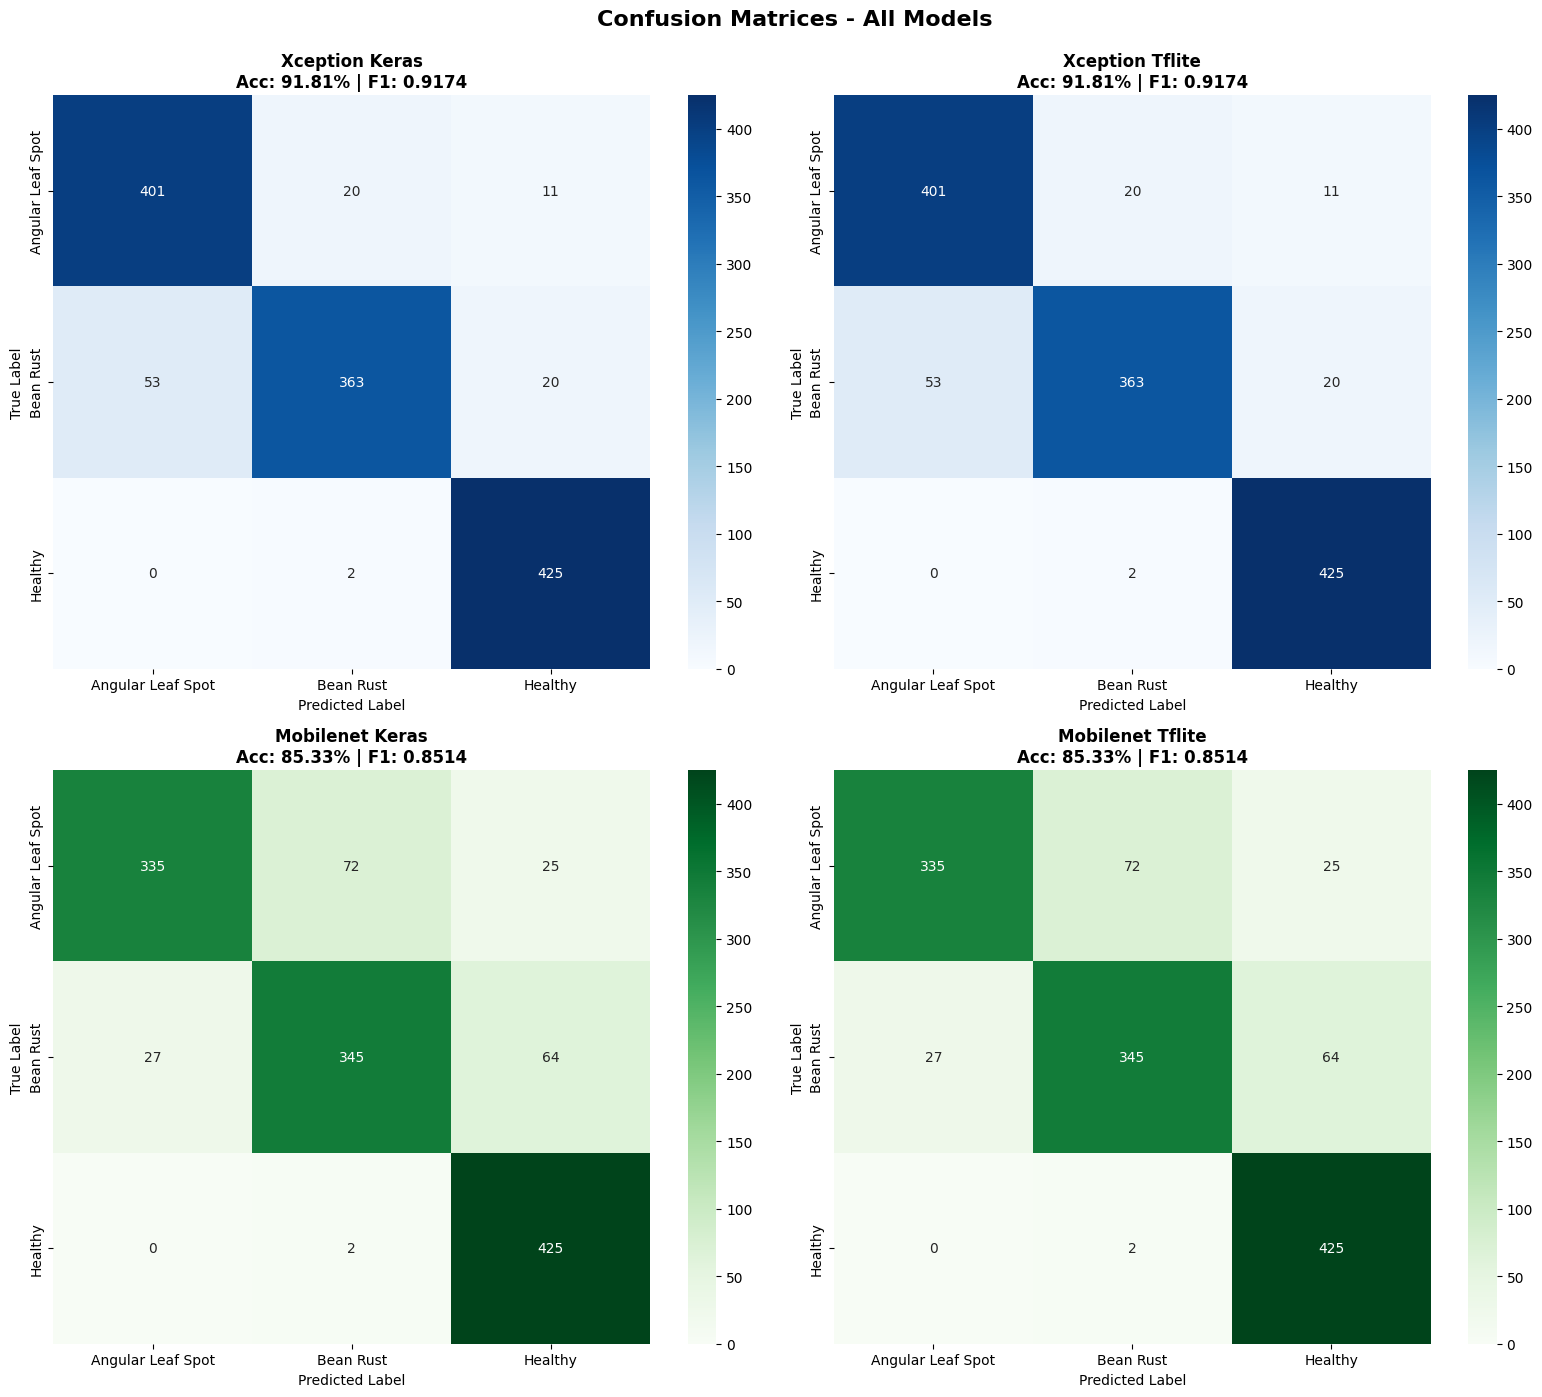

In [13]:
# Plot confusion matrices for all models
n_models = len(all_results)
if n_models > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()
    
    model_order = ['xception_keras', 'xception_tflite', 'mobilenet_keras', 'mobilenet_tflite']
    
    for idx, model_name in enumerate(model_order):
        if model_name not in all_results:
            axes[idx].text(0.5, 0.5, f'{model_name}\nNot Available', 
                          ha='center', va='center', fontsize=14, color='gray')
            axes[idx].axis('off')
            continue
        
        results = all_results[model_name]
        cm = confusion_matrix(all_labels, results['predictions'])
        
        cmap = 'Blues' if 'xception' in model_name else 'Greens'
        
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[idx])
        
        title = model_name.replace('_', ' ').title()
        axes[idx].set_title(f'{title}\nAcc: {results["accuracy"]*100:.2f}% | F1: {results["f1_macro"]:.4f}',
                           fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label', fontsize=10)
        axes[idx].set_xlabel('Predicted Label', fontsize=10)
    
    plt.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("No models evaluated")

## Per-Class Accuracy Comparison

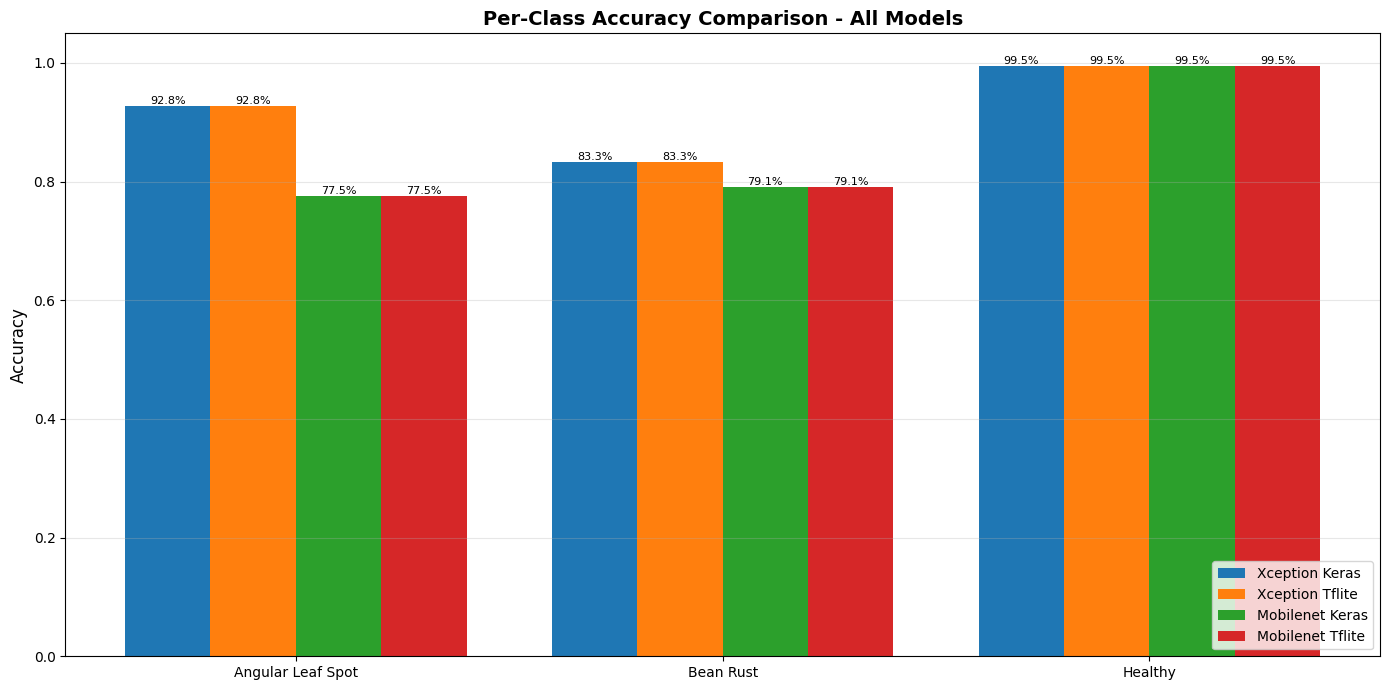

In [14]:
# Per-class accuracy comparison across all models
if len(all_results) > 0:
    # Calculate per-class accuracies for each model
    per_class_data = {}
    
    for model_name, results in all_results.items():
        per_class_acc = []
        for cls in range(N_CLASSES):
            mask = all_labels == cls
            cls_acc = np.mean(results['predictions'][mask] == all_labels[mask])
            per_class_acc.append(cls_acc)
        per_class_data[model_name] = per_class_acc
    
    # Plot grouped bar chart
    x = np.arange(N_CLASSES)
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    model_order = ['xception_keras', 'xception_tflite', 'mobilenet_keras', 'mobilenet_tflite']
    
    for idx, model_name in enumerate(model_order):
        if model_name not in per_class_data:
            continue
        offset = (idx - len(model_order)/2 + 0.5) * width
        bars = ax.bar(x + offset, per_class_data[model_name], width, 
                     label=model_name.replace('_', ' ').title(), 
                     color=colors[idx % len(colors)])
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height*100:.1f}%', ha='center', va='bottom', fontsize=8)
    
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Per-Class Accuracy Comparison - All Models', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(CLASS_NAMES)
    ax.legend(loc='lower right')
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No models evaluated")

In [15]:
# Final Summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

if len(all_results) > 0:
    print(f"\nEvaluated {len(all_results)} models on {len(all_labels)} images across {N_CLASSES} classes")
    
    # Best and worst performers
    best_acc_model = max(all_results.items(), key=lambda x: x[1]['accuracy'])
    worst_acc_model = min(all_results.items(), key=lambda x: x[1]['accuracy'])
    fastest_model = min(all_results.items(), key=lambda x: x[1]['inference_time_ms'])
    smallest_model = min(all_results.items(), key=lambda x: x[1]['size_mb'])
    
    print(f"\n🏆 Best Accuracy:")
    print(f"   {best_acc_model[0]}: {best_acc_model[1]['accuracy']*100:.2f}%")
    
    print(f"\n⚡ Fastest Inference:")
    print(f"   {fastest_model[0]}: {fastest_model[1]['inference_time_ms']:.2f} ms/image")
    
    print(f"\n📦 Smallest Size:")
    print(f"   {smallest_model[0]}: {smallest_model[1]['size_mb']:.2f} MB")
    
    if 'xception_keras' in all_results and 'mobilenet_tflite' in all_results:
        baseline = all_results['xception_keras']
        target = all_results['mobilenet_tflite']
        
        print(f"\n🎯 Deployment Recommendation:")
        print(f"   MobileNet TFLite offers:")
        print(f"   • {(1 - target['size_mb']/baseline['size_mb'])*100:.1f}% size reduction")
        print(f"   • {baseline['inference_time_ms']/target['inference_time_ms']:.2f}x speed improvement")
        print(f"   • Only {(baseline['accuracy'] - target['accuracy'])*100:.2f}% accuracy loss")
        print(f"   • Only {(baseline['f1_macro'] - target['f1_macro'])*100:.2f}% F1 score loss")
        
        if (baseline['accuracy'] - target['accuracy']) < 0.05:  # Less than 5% loss
            print(f"   ✓ Excellent trade-off for mobile deployment!")
        elif (baseline['accuracy'] - target['accuracy']) < 0.10:  # Less than 10% loss
            print(f"   ✓ Good trade-off for mobile deployment")
        else:
            print(f"   ⚠ Significant accuracy loss - consider if acceptable for use case")

else:
    print("\nNo models were evaluated")

print("\n" + "="*80)


FINAL SUMMARY

Evaluated 4 models on 1295 images across 3 classes

🏆 Best Accuracy:
   xception_keras: 91.81%

⚡ Fastest Inference:
   mobilenet_tflite: 14.12 ms/image

📦 Smallest Size:
   mobilenet_tflite: 12.22 MB

🎯 Deployment Recommendation:
   MobileNet TFLite offers:
   • 91.5% size reduction
   • 2.15x speed improvement
   • Only 6.49% accuracy loss
   • Only 6.60% F1 score loss
   ✓ Good trade-off for mobile deployment

